In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import imageio
import glob
import os

import warnings
warnings.simplefilter("ignore")

In [2]:

files_2020 = sorted(glob.glob("/g/data/ia39/aus-ref-clim-data-nci/gpm/data/V07/2020/3B-HHR.MS.MRG*.nc"))
files_2021 = sorted(glob.glob("/g/data/ia39/aus-ref-clim-data-nci/gpm/data/V07/2021/3B-HHR.MS.MRG*.nc"))
all_files = files_2020 + files_2021

# Dask
ds = xr.open_mfdataset(
    all_files,
    combine='by_coords',
    parallel=True,      
    chunks={'time': 1} 
)


In [3]:
print(ds)

<xarray.Dataset> Size: 10TB
Dimensions:                         (time: 34973, lon: 3600, lat: 1800, bnds: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * time                            (time) datetime64[ns] 280kB 2020-01-01 .....
Dimensions without coordinates: bnds
Data variables: (12/13)
    IRinfluence                     (time, lon, lat) float32 907GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 907GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    MWobservationTime               (time, lon, lat) timedelta64[ns] 2TB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    MWprecipSource                  (time, lon, lat) float32 907GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    MWprecipitation                 (time, lon, lat) float32 907GB dask.array<chunksize=(1, 6

In [4]:
ds.time

<xarray.DataArray 'time' (time: 34973)> Size: 280kB
array(['2020-01-01T00:00:00.000000000', '2020-01-01T00:30:00.000000000',
       '2020-01-01T01:00:00.000000000', ..., '2021-12-31T22:30:00.000000000',
       '2021-12-31T23:00:00.000000000', '2021-12-31T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 280kB 2020-01-01 ... 2021-12-31T23:30:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T

In [5]:

lons = ds.lon.values
lats = ds.lat.values


lon_res = lons[1] - lons[0]
lat_res = lats[1] - lats[0]

print(f"Longitude resolution: {lon_res} degrees")
print(f"Latitude resolution: {lat_res} degrees")


Longitude resolution: 0.0999908447265625 degrees
Latitude resolution: 0.09999847412109375 degrees


In [6]:
#ds_subset = ds.sel(time=slice("2020-01-20T00:00:00", "2021-04-01T00:00:00"))
ds_subset = ds.sel(time=slice("2020-01-20T00:00:00", "2020-01-24T00:00:00"))


In [7]:
print(ds_subset)


<xarray.Dataset> Size: 55GB
Dimensions:                         (time: 193, lon: 3600, lat: 1800, bnds: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * time                            (time) datetime64[ns] 2kB 2020-01-20 ... ...
Dimensions without coordinates: bnds
Data variables: (12/13)
    IRinfluence                     (time, lon, lat) float32 5GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 5GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    MWobservationTime               (time, lon, lat) timedelta64[ns] 10GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    MWprecipSource                  (time, lon, lat) float32 5GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    MWprecipitation                 (time, lon, lat) float32 5GB dask.array<chunksize=(1, 600, 600),

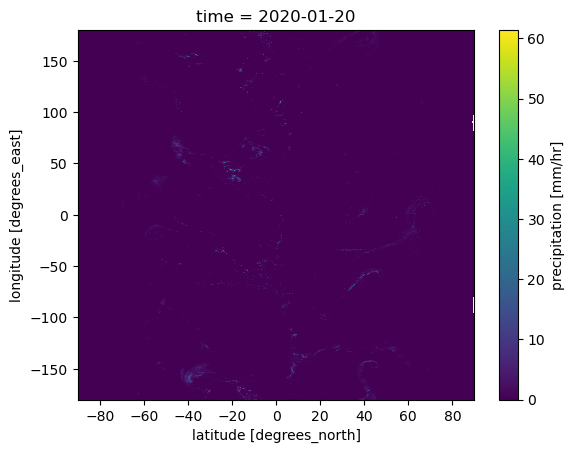

In [8]:
ds_subset.precipitation[0,:,:].plot()

In [9]:
rain_mc = ds_subset.precipitation.sel(
    lon=slice(100, 149),
    lat=slice(-10, 10)
)


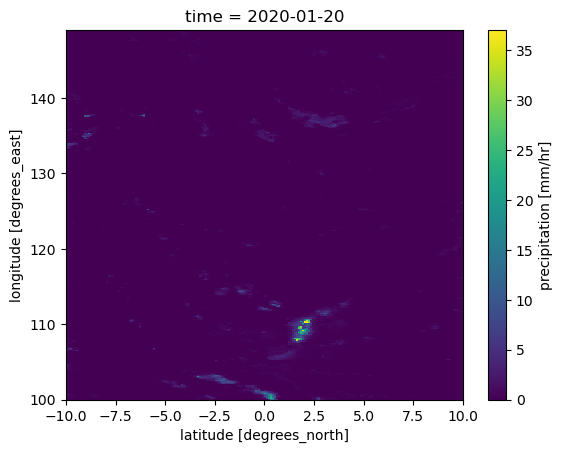

In [10]:
rain_mc[0,:,:].plot()


In [11]:
print(rain_mc)

<xarray.DataArray 'precipitation' (time: 193, lon: 490, lat: 200)> Size: 76MB
dask.array<getitem, shape=(193, 490, 200), dtype=float32, chunksize=(1, 290, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 800B -9.95 -9.85 -9.75 -9.65 ... 9.65 9.75 9.85 9.95
  * lon      (lon) float32 2kB 100.0 100.2 100.2 100.3 ... 148.8 148.8 148.9
  * time     (time) datetime64[ns] 2kB 2020-01-20 ... 2020-01-24
Attributes:
    units:             mm/hr
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    CodeMissingValue:  -9999.9
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    origname:          precipitation
    fullnamepath:      /Grid/precipitation


In [13]:
rain_mc_mm_day = rain_mc * 24
rain_daily = rain_mc_mm_day.resample(time="1D").mean()


In [14]:
rain_daily = rain_daily.sortby("lat")  # Ensure ascending lat order


In [ ]:


output_dir = "/scratch/up6/gs5098/hackathon2025/hk25-AusNode-DOCmeso/get_metrics/Greeshma/"

for i in range(rain_daily.time.size):
    day = rain_daily.isel(time=i)
    date_str = np.datetime_as_string(day.time.values, unit='D')

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    vmin = 0
    vmax = 50

    
    mesh = ax.pcolormesh(
        day['lon'], day['lat'], day.values.T,  # transpose to match x/y
        cmap="Blues", vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(f"Daily Mean Precipitation: {date_str}")
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

   
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', label='Daily Mean Precipitation (mm/day)')

    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    
    filename = os.path.join(output_dir, f"daily_mean_{date_str}.png")
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close(fig)


In [13]:


output_dir = "/scratch/up6/gs5098/hackathon2025/hk25-AusNode-DOCmeso/get_metrics/Greeshma/"
os.makedirs(output_dir, exist_ok=True)

rain_monthly = rain_mc.resample(time="1M").mean().compute()

vmin = 0
vmax = 40

for i in range(rain_monthly.time.size):
    month = rain_monthly.isel(time=i)
    date_str = np.datetime_as_string(month.time.values, unit='M')  # e.g., '2020-01'

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    month.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Blues",
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={'label': 'Monthly Mean Precipitation (mm/day)'}
    )

    ax.coastlines()
    ax.set_title(f"Monthly Mean Precipitation: {date_str}")

    # Add lat/lon gridlines and labels
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Optional: Add land for better context
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Save plot
    filename = os.path.join(output_dir, f"monthly_mean_{date_str}.png")
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close(fig)



KeyboardInterrupt



In [22]:
import os
import glob
import imageio.v2 as imageio
from natsort import natsorted

path_figs = "/scratch/up6/gs5098/hackathon2025/hk25-AusNode-DOCmeso/get_metrics/Greeshma"
name_all_figs = "monthly_mean"


path_f = natsorted(glob.glob(f"{path_figs}/{name_all_figs}_*.png"))

#GIF
frames = [imageio.imread(file) for file in path_f]
gif_path = f"{path_figs}/{name_all_figs}.gif"
imageio.mimsave(gif_path, frames, fps=2)

#Convert GIF to MP4 
mp4_path = f"{path_figs}/{name_all_figs}.mp4"
os.system(
    f'ffmpeg -y -i {gif_path} -movflags faststart -pix_fmt yuv420p '
    f'-vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" {mp4_path}'
)




ffmpeg version 7.0.2 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1726581252443/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1726581252443/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1726581252443/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1726581252443/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1726581252443/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libop

0